# Compass Heading vs. Standard Heading in Robotics

In robotics, heading (orientation) can be represented in different ways. The VEX system uses **compass heading**, while most mathematical and robotics conventions use **standard heading**. Understanding the difference is crucial for correct localization and sensor fusion.

**Compass Heading (VEX):**
- 0° points North (up), 90° is East (right), 180° is South (down), 270° is West (left)
- Increases clockwise
- Used by VEX IMU and some other sensors

**Standard Heading (Mathematical/Robotics):**
- 0° points East (right), 90° is North (up), 180° is West (left), 270° is South (down)
- Increases counterclockwise
- Used in most math libraries, trigonometry, and robotics literature

## Problems Caused by Compass vs. Standard Heading
- **Angle Wrapping:** Converting between systems can cause errors if not handled properly, especially near 0°/360° boundaries.
- **Trigonometric Functions:** `sin()` and `cos()` expect standard heading; using compass heading directly leads to incorrect calculations.
- **Sensor Fusion:** Mixing data from sensors using different conventions can result in inconsistent or incorrect pose estimates.
- **Debugging Difficulty:** Bugs related to heading conventions are often subtle and hard to trace.

**Best Practice:**
Always convert compass heading to standard heading before using it in calculations, and be consistent throughout your codebase.

## Transforming Sensor Position from Robot Frame to Field Frame

Robots often have sensors (like distance sensors or cameras) mounted at specific locations relative to the robot's center. To use these sensors for localization, we must translate their position from the robot's local coordinate frame to the global (field) coordinate frame.

**Key Steps:**
1. **Robot Frame:** The sensor's position is given relative to the robot's center (e.g., 6 inches forward, 4 inches left).
2. **Robot Pose:** The robot's pose on the field is defined by its (x, y) position and heading (angle).
3. **Transformation:** To find the sensor's global position, rotate the sensor's offset by the robot's heading and add it to the robot's field position.

This transformation is essential for correctly interpreting sensor readings in the context of the field.

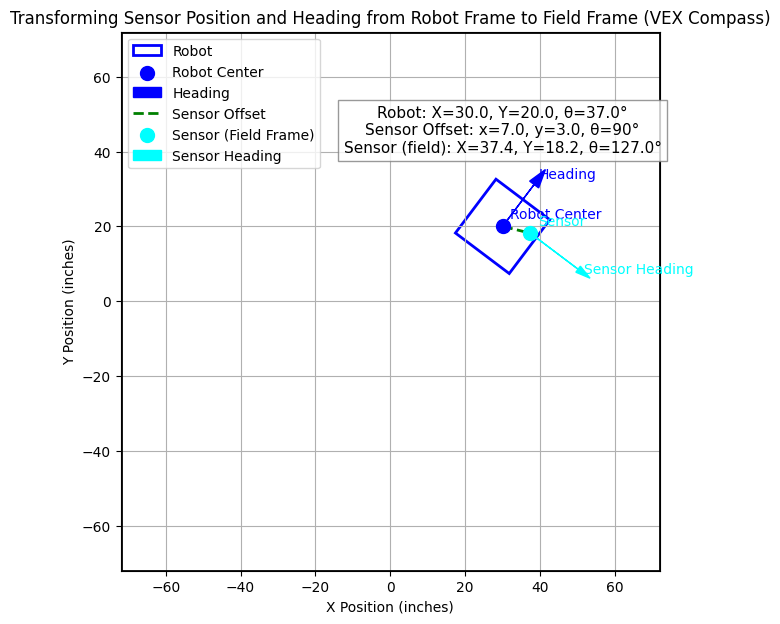

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# Visualize robot pose and sensor offset on VEX field
import matplotlib.patches as patches
from matplotlib.transforms import Affine2D

robot_size = 18

# Helper: convert compass heading (0=N, 90=E, 180=S, 270=W, CW) to standard math (0=E, CCW)
def compass_to_math_deg(compass_deg):
    return (90 - compass_deg) % 360

def compass_to_math_rad(compass_deg):
    return np.deg2rad(compass_to_math_deg(compass_deg))

# Robot pose in VEX field coordinates and compass heading
robot_field_x = 30
robot_field_y = 20
robot_heading_compass = 37  # degrees, compass (CW from North)
robot_theta = compass_to_math_rad(robot_heading_compass)

# Sensor offset in robot frame (x=right/left, y=forward/back) inches
# x = 7 (right of center), y = 3 (forward of center)
sensor_offset_robot = np.array([7, 3])  # 7 right, 3 forward
# Sensor heading in compass (90 = right side of robot)
sensor_heading_offset_compass = 90

# Sensor position in field frame: rotate offset by robot heading, then add to robot position
# For VEX robot frame (x=right, y=forward), the field offset is:
field_dx = sensor_offset_robot[1]*np.cos(robot_theta) + sensor_offset_robot[0]*np.sin(robot_theta)
field_dy = sensor_offset_robot[1]*np.sin(robot_theta) - sensor_offset_robot[0]*np.cos(robot_theta)
sensor_offset_field = np.array([field_dx, field_dy])
sensor_field_xy = np.array([robot_field_x, robot_field_y]) + sensor_offset_field

# Sensor heading in field frame (robot heading + sensor heading offset, both in compass)
sensor_heading_compass = (robot_heading_compass + sensor_heading_offset_compass) % 360
sensor_heading = compass_to_math_rad(sensor_heading_compass)

plt.figure(figsize=(7,7))
plt.plot([-72, 72, 72, -72, -72], [-72, -72, 72, 72, -72], 'k-', linewidth=2)
plt.xlim(-72, 72)
plt.ylim(-72, 72)
plt.gca().set_aspect('equal', adjustable='box')

# Draw robot as a rotated rectangle
robot_patch = patches.Rectangle((-robot_size/2, -robot_size/2), robot_size, robot_size, edgecolor='blue', facecolor='none', lw=2, label='Robot')
trans = Affine2D().rotate(robot_theta).translate(robot_field_x, robot_field_y) + plt.gca().transData
robot_patch.set_transform(trans)
plt.gca().add_patch(robot_patch)

# Draw robot center
plt.scatter(robot_field_x, robot_field_y, color='blue', s=100, zorder=5, label='Robot Center')
plt.text(robot_field_x+2, robot_field_y+2, 'Robot Center', color='blue')

# Draw robot heading
plt.arrow(robot_field_x, robot_field_y, 14*np.cos(robot_theta), 14*np.sin(robot_theta), head_width=3, head_length=5, fc='blue', ec='blue', label='Heading', zorder=4)
plt.text(robot_field_x+16*np.cos(robot_theta), robot_field_y+16*np.sin(robot_theta), 'Heading', color='blue')

# Draw sensor offset vector
plt.plot([robot_field_x, sensor_field_xy[0]], [robot_field_y, sensor_field_xy[1]], 'g--', lw=2, label='Sensor Offset')

# Draw sensor position (cyan)
plt.scatter(sensor_field_xy[0], sensor_field_xy[1], color='cyan', s=100, zorder=6, label='Sensor (Field Frame)')
plt.text(sensor_field_xy[0]+2, sensor_field_xy[1]+2, 'Sensor', color='cyan')

# Draw sensor heading vector (using compass heading, cyan)
plt.arrow(sensor_field_xy[0], sensor_field_xy[1], 16*np.cos(sensor_heading), 16*np.sin(sensor_heading), head_width=2, head_length=4, fc='cyan', ec='cyan', label='Sensor Heading', zorder=7)
plt.text(sensor_field_xy[0]+18*np.cos(sensor_heading), sensor_field_xy[1]+18*np.sin(sensor_heading), 'Sensor Heading', color='cyan')

# Add detailed legend entries just above the robot
legend_text = (
    f"Robot: X={robot_field_x:.1f}, Y={robot_field_y:.1f}, θ={robot_heading_compass:.1f}°\n"
    f"Sensor Offset: x={sensor_offset_robot[0]:.1f}, y={sensor_offset_robot[1]:.1f}, θ={sensor_heading_offset_compass}°\n"
    f"Sensor (field): X={sensor_field_xy[0]:.1f}, Y={sensor_field_xy[1]:.1f}, θ={sensor_heading_compass:.1f}°"
    )
plt.gca().legend(loc='upper left')
plt.gca().text(
    robot_field_x, robot_field_y + robot_size/2 + 10, legend_text,
    fontsize=11, va='bottom', ha='center',
    bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'),
    zorder=10
)

plt.xlabel('X Position (inches)')
plt.ylabel('Y Position (inches)')
plt.title('Transforming Sensor Position and Heading from Robot Frame to Field Frame (VEX Compass)')
plt.grid(True)
plt.show()

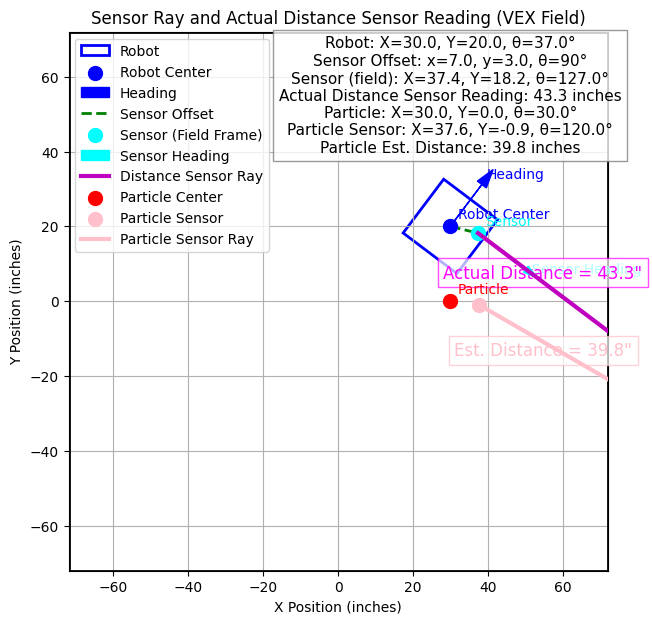

In [2]:
# Visualize sensor ray to wall and actual distance sensor reading, plus a particle's estimate
import matplotlib.patches as patches
from matplotlib.transforms import Affine2D

# Helper: compute intersection of a ray from (x0, y0) at angle theta with field boundaries
def distance_to_wall_from_point(x0, y0, theta, field_min=-72, field_max=72):
    dx = np.cos(theta)
    dy = np.sin(theta)
    t_vals = []
    # Vertical walls (x = field_min or field_max)
    if dx != 0:
        t1 = (field_min - x0) / dx
        t2 = (field_max - x0) / dx
        t_vals.extend([t1, t2])
    # Horizontal walls (y = field_min or field_max)
    if dy != 0:
        t3 = (field_min - y0) / dy
        t4 = (field_max - y0) / dy
        t_vals.extend([t3, t4])
    # Only consider positive t (forward)
    t_vals = [t for t in t_vals if t > 0]
    if not t_vals:
        return 0
    return min(t_vals)

# Robot pose in VEX field coordinates and compass heading
robot_field_x = 30
robot_field_y = 20
robot_heading_compass = 37  # degrees, compass (CW from North)
robot_theta = compass_to_math_rad(robot_heading_compass)

# Sensor offset in robot frame (x=right/left, y=forward/back) inches
# x = 7 (right of center), y = 3 (forward of center)
sensor_offset_robot = np.array([7, 3])  # 7 right, 3 forward
# Sensor heading in compass (90 = right side of robot)
sensor_heading_offset_compass = 90

# Sensor position in field frame: rotate offset by robot heading, then add to robot position
# For VEX robot frame (x=right, y=forward), the field offset is:
field_dx = sensor_offset_robot[1]*np.cos(robot_theta) + sensor_offset_robot[0]*np.sin(robot_theta)
field_dy = sensor_offset_robot[1]*np.sin(robot_theta) - sensor_offset_robot[0]*np.cos(robot_theta)
sensor_offset_field = np.array([field_dx, field_dy])
sensor_field_xy = np.array([robot_field_x, robot_field_y]) + sensor_offset_field

# Sensor heading in field frame (robot heading + sensor heading offset, both in compass)
sensor_heading_compass = (robot_heading_compass + sensor_heading_offset_compass) % 360
sensor_heading = compass_to_math_rad(sensor_heading_compass)

plt.figure(figsize=(7,7))
plt.plot([-72, 72, 72, -72, -72], [-72, -72, 72, 72, -72], 'k-', linewidth=2)
plt.xlim(-72, 72)
plt.ylim(-72, 72)
plt.gca().set_aspect('equal', adjustable='box')

# Draw robot as a rotated rectangle
robot_patch = patches.Rectangle((-robot_size/2, -robot_size/2), robot_size, robot_size, edgecolor='blue', facecolor='none', lw=2, label='Robot')
trans = Affine2D().rotate(robot_theta).translate(robot_field_x, robot_field_y) + plt.gca().transData
robot_patch.set_transform(trans)
plt.gca().add_patch(robot_patch)

# Draw robot center
plt.scatter(robot_field_x, robot_field_y, color='blue', s=100, zorder=5, label='Robot Center')
plt.text(robot_field_x+2, robot_field_y+2, 'Robot Center', color='blue')

# Draw robot heading
plt.arrow(robot_field_x, robot_field_y, 14*np.cos(robot_theta), 14*np.sin(robot_theta), head_width=3, head_length=5, fc='blue', ec='blue', label='Heading', zorder=4)
plt.text(robot_field_x+16*np.cos(robot_theta), robot_field_y+16*np.sin(robot_theta), 'Heading', color='blue')

# Draw sensor offset vector
plt.plot([robot_field_x, sensor_field_xy[0]], [robot_field_y, sensor_field_xy[1]], 'g--', lw=2, label='Sensor Offset')

# Draw sensor position (cyan)
plt.scatter(sensor_field_xy[0], sensor_field_xy[1], color='cyan', s=100, zorder=6, label='Sensor (Field Frame)')
plt.text(sensor_field_xy[0]+2, sensor_field_xy[1]+2, 'Sensor', color='cyan')

# Draw sensor heading vector (using compass heading, cyan)
plt.arrow(sensor_field_xy[0], sensor_field_xy[1], 16*np.cos(sensor_heading), 16*np.sin(sensor_heading), head_width=2, head_length=4, fc='cyan', ec='cyan', label='Sensor Heading', zorder=7)
plt.text(sensor_field_xy[0]+18*np.cos(sensor_heading), sensor_field_xy[1]+18*np.sin(sensor_heading), 'Sensor Heading', color='cyan')

# Compute and draw sensor ray to wall (actual)
distance = distance_to_wall_from_point(sensor_field_xy[0], sensor_field_xy[1], sensor_heading)
wall_x = sensor_field_xy[0] + distance * np.cos(sensor_heading)
wall_y = sensor_field_xy[1] + distance * np.sin(sensor_heading)
plt.plot([sensor_field_xy[0], wall_x], [sensor_field_xy[1], wall_y], 'm-', lw=3, label='Distance Sensor Ray', zorder=8)
# plt.scatter(wall_x, wall_y, color='magenta', s=80, zorder=9, label='Wall Hit Point')  # Removed
# Wall hit point label removed, keep only the distance label
plt.text((sensor_field_xy[0]+wall_x)/2, (sensor_field_xy[1]+wall_y)/2, f'Actual Distance = {distance:.1f}"', color='magenta', fontsize=12, ha='center', va='bottom', bbox=dict(facecolor='white', alpha=0.7, edgecolor='magenta'))

# --- Add a particle at x=30, y=0, theta=30 (compass) ---
# Particle pose
particle_x = 30
particle_y = 0
particle_theta_compass = 30
particle_theta = compass_to_math_rad(particle_theta_compass)
# Particle sensor position (same offset)
particle_sensor_offset_field = np.array([
    sensor_offset_robot[1]*np.cos(particle_theta) + sensor_offset_robot[0]*np.sin(particle_theta),
    sensor_offset_robot[1]*np.sin(particle_theta) - sensor_offset_robot[0]*np.cos(particle_theta)
])
particle_sensor_xy = np.array([particle_x, particle_y]) + particle_sensor_offset_field
# Particle sensor heading in field frame
particle_sensor_heading_compass = (particle_theta_compass + sensor_heading_offset_compass) % 360
particle_sensor_heading = compass_to_math_rad(particle_sensor_heading_compass)
# Particle sensor ray to wall
particle_distance = distance_to_wall_from_point(particle_sensor_xy[0], particle_sensor_xy[1], particle_sensor_heading)
particle_wall_x = particle_sensor_xy[0] + particle_distance * np.cos(particle_sensor_heading)
particle_wall_y = particle_sensor_xy[1] + particle_distance * np.sin(particle_sensor_heading)

# Draw particle center (red)
plt.scatter(particle_x, particle_y, color='red', s=100, zorder=10, label='Particle Center')
plt.text(particle_x+2, particle_y+2, 'Particle', color='red')

# Draw particle sensor and ray (pink)
plt.scatter(particle_sensor_xy[0], particle_sensor_xy[1], color='pink', s=100, zorder=11, label='Particle Sensor')
plt.plot([particle_sensor_xy[0], particle_wall_x], [particle_sensor_xy[1], particle_wall_y], color='pink', lw=3, label='Particle Sensor Ray', zorder=12)
# plt.scatter(particle_wall_x, particle_wall_y, color='gold', s=80, zorder=13, label='Particle Wall Hit')  # Removed
# Wall hit point label removed, keep only the distance label
plt.text((particle_sensor_xy[0]+particle_wall_x)/2, (particle_sensor_xy[1]+particle_wall_y)/2, f'Est. Distance = {particle_distance:.1f}"', color='pink', fontsize=12, ha='center', va='top', bbox=dict(facecolor='white', alpha=0.7, edgecolor='pink'))

# Add detailed legend entries just above the robot
legend_text = (
    f"Robot: X={robot_field_x:.1f}, Y={robot_field_y:.1f}, θ={robot_heading_compass:.1f}°\n"
    f"Sensor Offset: x={sensor_offset_robot[0]:.1f}, y={sensor_offset_robot[1]:.1f}, θ={sensor_heading_offset_compass}°\n"
    f"Sensor (field): X={sensor_field_xy[0]:.1f}, Y={sensor_field_xy[1]:.1f}, θ={sensor_heading_compass:.1f}°\n"
    f"Actual Distance Sensor Reading: {distance:.1f} inches\n"
    f"Particle: X={particle_x:.1f}, Y={particle_y:.1f}, θ={particle_theta_compass:.1f}°\n"
    f"Particle Sensor: X={particle_sensor_xy[0]:.1f}, Y={particle_sensor_xy[1]:.1f}, θ={particle_sensor_heading_compass:.1f}°\n"
    f"Particle Est. Distance: {particle_distance:.1f} inches"
)
plt.gca().legend(loc='upper left')
plt.gca().text(
    robot_field_x, robot_field_y + robot_size/2 + 10, legend_text,
    fontsize=11, va='bottom', ha='center',
    bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'),
    zorder=10
)

plt.xlabel('X Position (inches)')
plt.ylabel('Y Position (inches)')
plt.title('Sensor Ray and Actual Distance Sensor Reading (VEX Field)')
plt.grid(True)
plt.show()

## Comparing Expected and Actual Sensor Readings in the Particle Filter

In a particle filter for robot localization, each particle represents a possible pose (position and orientation) of the robot. To determine which particles are more likely to represent the true state, the filter uses the robot's sensor readings.

Here's how the comparison works:
- **For each particle:** The filter computes the *expected* sensor reading (e.g., the distance from the particle's sensor to the nearest wall), based on the particle's pose and the known map of the environment.
- **Actual sensor value:** The robot's real sensor provides a measurement (e.g., the actual distance to the wall from the robot's true pose).
- **Comparison:** The filter compares the expected reading for each particle to the actual sensor value. Particles whose expected readings closely match the actual sensor value are considered more likely to be correct.
- **Weighting:** Each particle is assigned a weight based on how well its expected reading matches the actual sensor value. Typically, this is done using a probability distribution (such as a Gaussian) centered at the actual sensor value.
- **Resampling:** Particles with higher weights are more likely to be selected during the resampling step, focusing the filter on the most probable regions of the state space.

This process allows the particle filter to use sensor data to correct for errors in motion estimation and to recover from uncertainty or ambiguity in the robot's pose.

**Note:** In the main tracking plot below, the 'Noisy Position Measurements' are simulated as if the robot's position was measured directly with some noise. In a real robot, these would come from sensor fusion (e.g., GPS, vision, or multiple distance sensors), but here they are used to demonstrate the particle filter's ability to estimate the true position from noisy data. The rays and wall distances are visualized in the next cell for clarity.

## Visualizing the Particle Filter Process
Now we'll walk through the main stages of the particle filter, visualizing each step:
1. **Initialization:** Particles are randomly distributed across the field.
2. **Prediction (Motion Update):** Particles are moved according to the robot's motion model.
3. **Measurement Update (Weighting):** Each particle is weighted based on how well its expected sensor reading matches the actual sensor value.
4. **Resampling:** Particles are resampled according to their weights, focusing on the most likely regions.

Each plot below will illustrate one of these steps.

### Particle Filter Step 1: Initialization (Explainer)

In the **initialization phase**, we create a bunch of "particles" to represent all the possible places and directions the robot could be on the field. Each particle is like a guess about where the robot might be. We usually start by spreading them out in a cloud around where we think the robot is, but with some randomness to account for uncertainty. Each particle has its own position and heading (direction).

Think of it like having 20 friends each stand in a slightly different spot and face a slightly different direction, all near where you think the robot is. This gives the filter a starting point to work from.

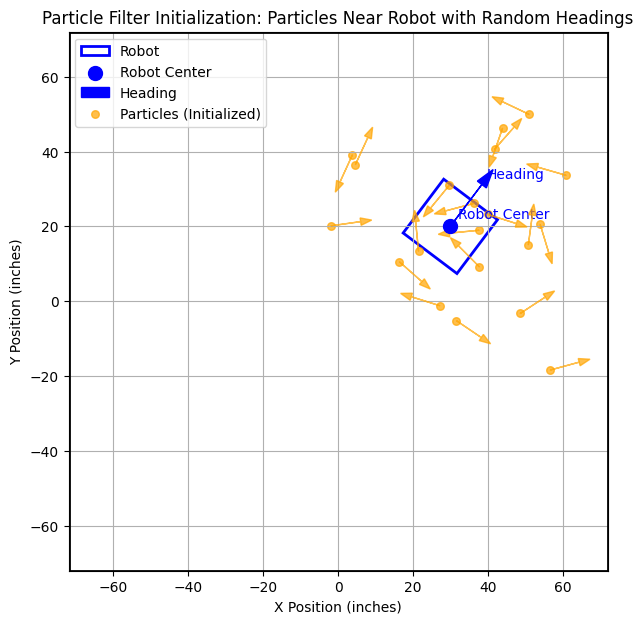

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.transforms import Affine2D

# Field and robot parameters
robot_size = 18
field_min, field_max = -72, 72

# Robot pose
robot_field_x = 30
robot_field_y = 20
robot_heading_compass = 37
def compass_to_math_deg(compass_deg):
    return (90 - compass_deg) % 360
def compass_to_math_rad(compass_deg):
    return np.deg2rad(compass_to_math_deg(compass_deg))
robot_theta = compass_to_math_rad(robot_heading_compass)

# Particle filter initialization: distribute particles in a Gaussian cloud near the robot, with random headings
num_particles = 20
init_std = 18  # standard deviation in inches
particles_x = np.random.normal(robot_field_x, init_std, num_particles)
particles_y = np.random.normal(robot_field_y, init_std, num_particles)
particles_heading = np.random.uniform(0, 360, num_particles)  # compass headings
particles_theta = np.deg2rad((90 - particles_heading) % 360)  # convert to math radians

plt.figure(figsize=(7,7))
plt.plot([field_min, field_max, field_max, field_min, field_min], [field_min, field_min, field_max, field_max, field_min], 'k-', linewidth=2)
plt.xlim(field_min, field_max)
plt.ylim(field_min, field_max)
plt.gca().set_aspect('equal', adjustable='box')

# Draw robot as a rotated rectangle
robot_patch = patches.Rectangle((-robot_size/2, -robot_size/2), robot_size, robot_size, edgecolor='blue', facecolor='none', lw=2, label='Robot')
trans = Affine2D().rotate(robot_theta).translate(robot_field_x, robot_field_y) + plt.gca().transData
robot_patch.set_transform(trans)
plt.gca().add_patch(robot_patch)

# Draw robot center
plt.scatter(robot_field_x, robot_field_y, color='blue', s=100, zorder=5, label='Robot Center')
plt.text(robot_field_x+2, robot_field_y+2, 'Robot Center', color='blue')

# Draw robot heading
plt.arrow(robot_field_x, robot_field_y, 14*np.cos(robot_theta), 14*np.sin(robot_theta), head_width=3, head_length=5, fc='blue', ec='blue', label='Heading', zorder=4)
plt.text(robot_field_x+16*np.cos(robot_theta), robot_field_y+16*np.sin(robot_theta), 'Heading', color='blue')

# Draw particles (initialization phase)
plt.scatter(particles_x, particles_y, color='orange', s=30, alpha=0.7, label='Particles (Initialized)')
# Draw particle headings as small arrows
for x, y, theta in zip(particles_x, particles_y, particles_theta):
    plt.arrow(x, y, 8*np.cos(theta), 8*np.sin(theta), head_width=2, head_length=3, fc='orange', ec='orange', alpha=0.7, zorder=3)

plt.gca().legend(loc='upper left')
plt.xlabel('X Position (inches)')
plt.ylabel('Y Position (inches)')
plt.title('Particle Filter Initialization: Particles Near Robot with Random Headings')
plt.grid(True)
plt.show()

### Particle Filter Step 2: Prediction (Motion Update) (Explainer)

In the **prediction phase**, we move each particle forward based on how we think the robot actually moved (for example, "drive forward 8 inches"). We also add a little bit of randomness to each particle's movement to represent real-world errors, like slipping wheels or uneven floors. This step helps the filter "guess" where the robot and all the particles might be after the robot moves.

Imagine all your friends take a step forward in the direction they're facing, but each one steps a little differently. This models the uncertainty in the robot's movement.

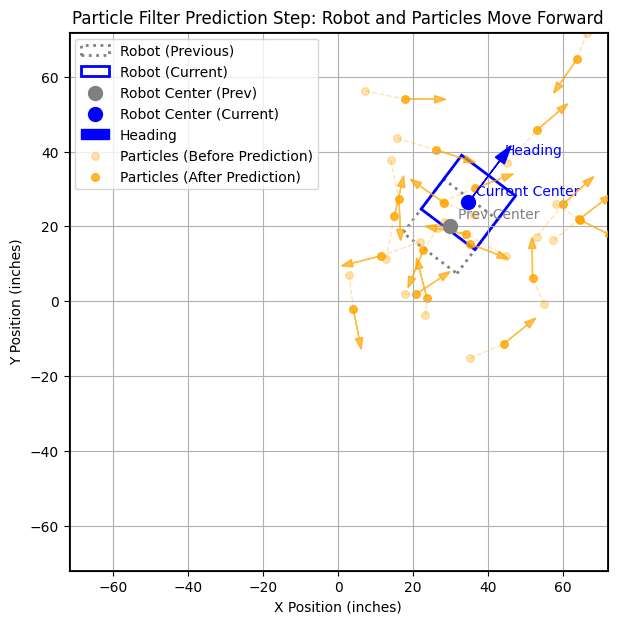

In [4]:
# Particle Filter Prediction Step: Move particles forward along their heading with noise
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.transforms import Affine2D

# Use the same robot pose and field as before
robot_size = 18
field_min, field_max = -72, 72
robot_field_x = 30
robot_field_y = 20
robot_heading_compass = 37
def compass_to_math_deg(compass_deg):
    return (90 - compass_deg) % 360
def compass_to_math_rad(compass_deg):
    return np.deg2rad(compass_to_math_deg(compass_deg))
robot_theta = compass_to_math_rad(robot_heading_compass)

# Re-initialize particles as in previous cell (for standalone execution)
num_particles = 20
init_std = 18
particles_x = np.random.normal(robot_field_x, init_std, num_particles)
particles_y = np.random.normal(robot_field_y, init_std, num_particles)
particles_heading = np.random.uniform(0, 360, num_particles)  # compass headings
particles_theta = np.deg2rad((90 - particles_heading) % 360)  # math radians

# Prediction step: move each particle forward along its heading, add noise
move_distance = 8  # inches forward
motion_noise_std = 2.0
particles_x_pred = particles_x + move_distance * np.cos(particles_theta) + np.random.normal(0, motion_noise_std, num_particles)
particles_y_pred = particles_y + move_distance * np.sin(particles_theta) + np.random.normal(0, motion_noise_std, num_particles)
particles_theta_pred = particles_theta + np.random.normal(0, np.deg2rad(5), num_particles)  # add heading noise

# --- Robot movement: show previous and current robot positions ---
# For demo, move robot forward along its heading by move_distance (no noise)
robot_field_x_prev = robot_field_x
robot_field_y_prev = robot_field_y
robot_field_x_new = robot_field_x + move_distance * np.cos(robot_theta)
robot_field_y_new = robot_field_y + move_distance * np.sin(robot_theta)

plt.figure(figsize=(7,7))
plt.plot([field_min, field_max, field_max, field_min, field_min], [field_min, field_min, field_max, field_max, field_min], 'k-', linewidth=2)
plt.xlim(field_min, field_max)
plt.ylim(field_min, field_max)
plt.gca().set_aspect('equal', adjustable='box')

# Draw previous robot position as a dotted rectangle
robot_patch_prev = patches.Rectangle((-robot_size/2, -robot_size/2), robot_size, robot_size, edgecolor='gray', facecolor='none', lw=2, linestyle='dotted', label='Robot (Previous)')
trans_prev = Affine2D().rotate(robot_theta).translate(robot_field_x_prev, robot_field_y_prev) + plt.gca().transData
robot_patch_prev.set_transform(trans_prev)
plt.gca().add_patch(robot_patch_prev)

# Draw current robot as a solid rectangle
robot_patch = patches.Rectangle((-robot_size/2, -robot_size/2), robot_size, robot_size, edgecolor='blue', facecolor='none', lw=2, label='Robot (Current)')
trans = Affine2D().rotate(robot_theta).translate(robot_field_x_new, robot_field_y_new) + plt.gca().transData
robot_patch.set_transform(trans)
plt.gca().add_patch(robot_patch)

# Draw robot centers
plt.scatter(robot_field_x_prev, robot_field_y_prev, color='gray', s=100, zorder=5, label='Robot Center (Prev)')
plt.scatter(robot_field_x_new, robot_field_y_new, color='blue', s=100, zorder=5, label='Robot Center (Current)')
plt.text(robot_field_x_prev+2, robot_field_y_prev+2, 'Prev Center', color='gray')
plt.text(robot_field_x_new+2, robot_field_y_new+2, 'Current Center', color='blue')

# Draw robot heading (current)
plt.arrow(robot_field_x_new, robot_field_y_new, 14*np.cos(robot_theta), 14*np.sin(robot_theta), head_width=3, head_length=5, fc='blue', ec='blue', label='Heading', zorder=4)
plt.text(robot_field_x_new+16*np.cos(robot_theta), robot_field_y_new+16*np.sin(robot_theta), 'Heading', color='blue')

# Draw previous particle positions (faint orange)
plt.scatter(particles_x, particles_y, color='orange', s=30, alpha=0.3, label='Particles (Before Prediction)')
# Draw predicted particle positions (solid orange)
plt.scatter(particles_x_pred, particles_y_pred, color='orange', s=30, alpha=0.8, label='Particles (After Prediction)')

# Connect before/after dots for each particle
for x0, y0, x1, y1 in zip(particles_x, particles_y, particles_x_pred, particles_y_pred):
    plt.plot([x0, x1], [y0, y1], color='orange', alpha=0.3, linewidth=1, linestyle='--', zorder=2)

# Draw predicted headings as arrows
for x, y, theta in zip(particles_x_pred, particles_y_pred, particles_theta_pred):
    plt.arrow(x, y, 8*np.cos(theta), 8*np.sin(theta), head_width=2, head_length=3, fc='orange', ec='orange', alpha=0.7, zorder=3)

plt.gca().legend(loc='upper left')
plt.xlabel('X Position (inches)')
plt.ylabel('Y Position (inches)')
plt.title('Particle Filter Prediction Step: Robot and Particles Move Forward')
plt.grid(True)
plt.show()

### Particle Filter Step 3: Measurement Update (Explainer)

In the **measurement update phase**, we use the robot's sensor (like a distance sensor) to check how well each particle's guess matches what the robot actually senses. For each particle, we calculate what the sensor *should* read if the robot were really at that particle's position. Then, we compare that to the robot's real sensor reading. If a particle's guess is close to the real reading, it gets a higher "weight" (meaning it's more likely to be correct). If it's way off, it gets a lower weight.

It's like asking each friend, "If you were the robot, what would your sensor see?" The friends whose answers are closest to the real sensor reading are more likely to be right.

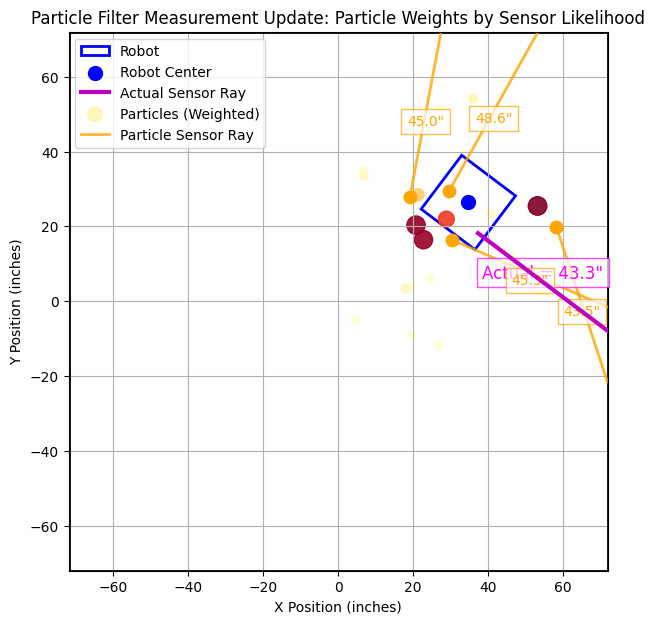

In [5]:
# Particle Filter Measurement Update: Weight particles by sensor likelihood and visualize weights
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.transforms import Affine2D

# Use the same robot pose and field as before
robot_size = 18
field_min, field_max = -72, 72
robot_field_x = 30
robot_field_y = 20
robot_heading_compass = 37
def compass_to_math_deg(compass_deg):
    return (90 - compass_deg) % 360
def compass_to_math_rad(compass_deg):
    return np.deg2rad(compass_to_math_deg(compass_deg))
robot_theta = compass_to_math_rad(robot_heading_compass)

# Use the same particles as after prediction step
num_particles = 20
init_std = 18
np.random.seed(42)  # For reproducibility
particles_x = np.random.normal(robot_field_x, init_std, num_particles)
particles_y = np.random.normal(robot_field_y, init_std, num_particles)
particles_heading = np.random.uniform(0, 360, num_particles)  # compass headings
particles_theta = np.deg2rad((90 - particles_heading) % 360)  # math radians
move_distance = 8
motion_noise_std = 2.0
particles_x_pred = particles_x + move_distance * np.cos(particles_theta) + np.random.normal(0, motion_noise_std, num_particles)
particles_y_pred = particles_y + move_distance * np.sin(particles_theta) + np.random.normal(0, motion_noise_std, num_particles)
particles_theta_pred = particles_theta + np.random.normal(0, np.deg2rad(5), num_particles)

# Sensor offset and heading (same as before)
sensor_offset_robot = np.array([7, 3])  # 7 right, 3 forward
sensor_heading_offset_compass = 90

def distance_to_wall_from_point(x0, y0, theta, field_min=-72, field_max=72):
    dx = np.cos(theta)
    dy = np.sin(theta)
    t_vals = []
    if dx != 0:
        t1 = (field_min - x0) / dx
        t2 = (field_max - x0) / dx
        t_vals.extend([t1, t2])
    if dy != 0:
        t3 = (field_min - y0) / dy
        t4 = (field_max - y0) / dy
        t_vals.extend([t3, t4])
    t_vals = [t for t in t_vals if t > 0]
    if not t_vals:
        return 0
    return min(t_vals)

# Actual sensor reading from robot's true pose
robot_sensor_offset_field = np.array([
    sensor_offset_robot[1]*np.cos(robot_theta) + sensor_offset_robot[0]*np.sin(robot_theta),
    sensor_offset_robot[1]*np.sin(robot_theta) - sensor_offset_robot[0]*np.cos(robot_theta)
])
robot_sensor_xy = np.array([robot_field_x, robot_field_y]) + robot_sensor_offset_field
robot_sensor_heading_compass = (robot_heading_compass + sensor_heading_offset_compass) % 360
robot_sensor_heading = compass_to_math_rad(robot_sensor_heading_compass)
actual_sensor_reading = distance_to_wall_from_point(robot_sensor_xy[0], robot_sensor_xy[1], robot_sensor_heading)

# For each particle, compute expected sensor reading and weight
particle_sensor_xy = []
particle_sensor_heading = []
particle_expected_reading = []
for x, y, theta, heading_compass in zip(particles_x_pred, particles_y_pred, particles_theta_pred, (90 - np.rad2deg(particles_theta_pred)) % 360):
    # Sensor position for this particle
    offset_field = np.array([
        sensor_offset_robot[1]*np.cos(theta) + sensor_offset_robot[0]*np.sin(theta),
        sensor_offset_robot[1]*np.sin(theta) - sensor_offset_robot[0]*np.cos(theta)
    ])
    sensor_xy = np.array([x, y]) + offset_field
    sensor_heading_compass = (heading_compass + sensor_heading_offset_compass) % 360
    sensor_heading = compass_to_math_rad(sensor_heading_compass)
    particle_sensor_xy.append(sensor_xy)
    particle_sensor_heading.append(sensor_heading)
    expected = distance_to_wall_from_point(sensor_xy[0], sensor_xy[1], sensor_heading)
    particle_expected_reading.append(expected)
particle_sensor_xy = np.array(particle_sensor_xy)
particle_sensor_heading = np.array(particle_sensor_heading)
particle_expected_reading = np.array(particle_expected_reading)

# Compute weights: Gaussian likelihood of expected vs. actual
sensor_std = 6.0  # inches
weights = np.exp(-0.5 * ((particle_expected_reading - actual_sensor_reading)/sensor_std)**2)
weights /= np.sum(weights)

# Visualize: color/size by weight
plt.figure(figsize=(7,7))
plt.plot([field_min, field_max, field_max, field_min, field_min], [field_min, field_min, field_max, field_max, field_min], 'k-', linewidth=2)
plt.xlim(field_min, field_max)
plt.ylim(field_min, field_max)
plt.gca().set_aspect('equal', adjustable='box')

# Draw robot as a rectangle at new position
robot_patch = patches.Rectangle((-robot_size/2, -robot_size/2), robot_size, robot_size, edgecolor='blue', facecolor='none', lw=2, label='Robot')
trans = Affine2D().rotate(robot_theta).translate(robot_field_x + move_distance * np.cos(robot_theta), robot_field_y + move_distance * np.sin(robot_theta)) + plt.gca().transData
robot_patch.set_transform(trans)
plt.gca().add_patch(robot_patch)
plt.scatter(robot_field_x + move_distance * np.cos(robot_theta), robot_field_y + move_distance * np.sin(robot_theta), color='blue', s=100, zorder=5, label='Robot Center')

# Draw actual sensor ray
wall_x = robot_sensor_xy[0] + actual_sensor_reading * np.cos(robot_sensor_heading)
wall_y = robot_sensor_xy[1] + actual_sensor_reading * np.sin(robot_sensor_heading)
plt.plot([robot_sensor_xy[0], wall_x], [robot_sensor_xy[1], wall_y], 'm-', lw=3, label='Actual Sensor Ray', zorder=8)
plt.text((robot_sensor_xy[0]+wall_x)/2, (robot_sensor_xy[1]+wall_y)/2, f'Actual = {actual_sensor_reading:.1f}"', color='magenta', fontsize=12, ha='center', va='bottom', bbox=dict(facecolor='white', alpha=0.7, edgecolor='magenta'))

# Draw particles, color/size by weight
max_size = 180
min_size = 30
sizes = min_size + (max_size - min_size) * (weights - weights.min()) / (weights.max() - weights.min() + 1e-8)
plt.scatter(particles_x_pred, particles_y_pred, s=sizes, c=weights, cmap='YlOrRd', alpha=0.9, label='Particles (Weighted)')

# Draw expected sensor rays for a few top-weighted particles
top_idx = np.argsort(weights)[-4:]
for i in top_idx:
    sx, sy = particle_sensor_xy[i]
    heading = particle_sensor_heading[i]
    expected = particle_expected_reading[i]
    wx = sx + expected * np.cos(heading)
    wy = sy + expected * np.sin(heading)
    plt.plot([sx, wx], [sy, wy], color='orange', lw=2, alpha=0.8, label='Particle Sensor Ray' if i == top_idx[0] else None)
    plt.scatter(sx, sy, color='orange', s=80, zorder=10)
    plt.text((sx+wx)/2, (sy+wy)/2, f'{expected:.1f}"', color='orange', fontsize=10, ha='center', va='top', bbox=dict(facecolor='white', alpha=0.7, edgecolor='orange'))

plt.gca().legend(loc='upper left')
plt.xlabel('X Position (inches)')
plt.ylabel('Y Position (inches)')
plt.title('Particle Filter Measurement Update: Particle Weights by Sensor Likelihood')
plt.grid(True)
plt.show()


### Particle Filter Step 4: Resampling (Explainer)

In the **resampling phase**, we use the weights from the previous step to decide which particles to keep and which to drop. Particles with higher weights (the better guesses) are more likely to be chosen, and some may be picked more than once. Particles with low weights might be dropped. This step helps the filter focus on the most likely locations for the robot.

Imagine you ask your friends to line up again, but this time, the friends whose guesses were closest to the real sensor reading get to stand in the line more often, while those with bad guesses might have to sit out. This way, the group of guesses gets better and better at tracking where the robot really is.

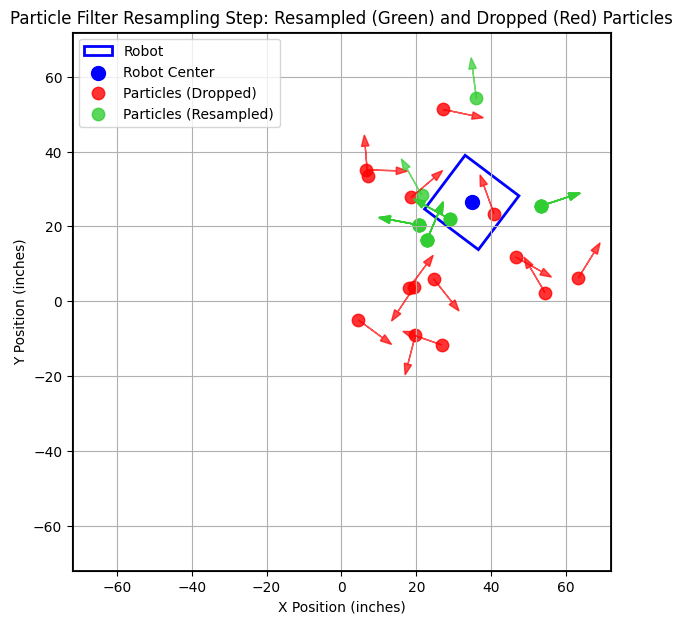

In [6]:
# Particle Filter Resampling Step: Visualize resampled particles and dropped ones
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.transforms import Affine2D

# Use the same robot pose and field as before
robot_size = 18
field_min, field_max = -72, 72
robot_field_x = 30
robot_field_y = 20
robot_heading_compass = 37
def compass_to_math_deg(compass_deg):
    return (90 - compass_deg) % 360
def compass_to_math_rad(compass_deg):
    return np.deg2rad(compass_to_math_deg(compass_deg))
robot_theta = compass_to_math_rad(robot_heading_compass)

# Use the same predicted particles and weights as previous cell
num_particles = 20
init_std = 18
np.random.seed(42)
particles_x = np.random.normal(robot_field_x, init_std, num_particles)
particles_y = np.random.normal(robot_field_y, init_std, num_particles)
particles_heading = np.random.uniform(0, 360, num_particles)
particles_theta = np.deg2rad((90 - particles_heading) % 360)
move_distance = 8
motion_noise_std = 2.0
particles_x_pred = particles_x + move_distance * np.cos(particles_theta) + np.random.normal(0, motion_noise_std, num_particles)
particles_y_pred = particles_y + move_distance * np.sin(particles_theta) + np.random.normal(0, motion_noise_std, num_particles)
particles_theta_pred = particles_theta + np.random.normal(0, np.deg2rad(5), num_particles)

# Sensor offset and heading (same as before)
sensor_offset_robot = np.array([7, 3])
sensor_heading_offset_compass = 90

def distance_to_wall_from_point(x0, y0, theta, field_min=-72, field_max=72):
    dx = np.cos(theta)
    dy = np.sin(theta)
    t_vals = []
    if dx != 0:
        t1 = (field_min - x0) / dx
        t2 = (field_max - x0) / dx
        t_vals.extend([t1, t2])
    if dy != 0:
        t3 = (field_min - y0) / dy
        t4 = (field_max - y0) / dy
        t_vals.extend([t3, t4])
    t_vals = [t for t in t_vals if t > 0]
    if not t_vals:
        return 0
    return min(t_vals)

# Actual sensor reading from robot's true pose
robot_sensor_offset_field = np.array([
    sensor_offset_robot[1]*np.cos(robot_theta) + sensor_offset_robot[0]*np.sin(robot_theta),
    sensor_offset_robot[1]*np.sin(robot_theta) - sensor_offset_robot[0]*np.cos(robot_theta)
])
robot_sensor_xy = np.array([robot_field_x, robot_field_y]) + robot_sensor_offset_field
robot_sensor_heading_compass = (robot_heading_compass + sensor_heading_offset_compass) % 360
robot_sensor_heading = compass_to_math_rad(robot_sensor_heading_compass)
actual_sensor_reading = distance_to_wall_from_point(robot_sensor_xy[0], robot_sensor_xy[1], robot_sensor_heading)

# For each particle, compute expected sensor reading and weight
particle_sensor_xy = []
particle_sensor_heading = []
particle_expected_reading = []
for x, y, theta, heading_compass in zip(particles_x_pred, particles_y_pred, particles_theta_pred, (90 - np.rad2deg(particles_theta_pred)) % 360):
    offset_field = np.array([
        sensor_offset_robot[1]*np.cos(theta) + sensor_offset_robot[0]*np.sin(theta),
        sensor_offset_robot[1]*np.sin(theta) - sensor_offset_robot[0]*np.cos(theta)
    ])
    sensor_xy = np.array([x, y]) + offset_field
    sensor_heading_compass = (heading_compass + sensor_heading_offset_compass) % 360
    sensor_heading = compass_to_math_rad(sensor_heading_compass)
    particle_sensor_xy.append(sensor_xy)
    particle_sensor_heading.append(sensor_heading)
    expected = distance_to_wall_from_point(sensor_xy[0], sensor_xy[1], sensor_heading)
    particle_expected_reading.append(expected)
particle_sensor_xy = np.array(particle_sensor_xy)
particle_sensor_heading = np.array(particle_sensor_heading)
particle_expected_reading = np.array(particle_expected_reading)

# Compute weights: Gaussian likelihood of expected vs. actual
sensor_std = 6.0
weights = np.exp(-0.5 * ((particle_expected_reading - actual_sensor_reading)/sensor_std)**2)
weights /= np.sum(weights)

# Resample particles according to weights (systematic resampling)
cumulative_sum = np.cumsum(weights)
cumulative_sum[-1] = 1.0  # ensure sum is exactly 1
indexes = np.searchsorted(cumulative_sum, np.linspace(0, 1-1/num_particles, num_particles))
resampled_x = particles_x_pred[indexes]
resampled_y = particles_y_pred[indexes]
resampled_theta = particles_theta_pred[indexes]

# Identify dropped particles (those not selected in resampling)
all_idx = set(range(num_particles))
resampled_set = set(indexes)
dropped_idx = list(all_idx - resampled_set)

plt.figure(figsize=(7,7))
plt.plot([field_min, field_max, field_max, field_min, field_min], [field_min, field_min, field_max, field_max, field_min], 'k-', linewidth=2)
plt.xlim(field_min, field_max)
plt.ylim(field_min, field_max)
plt.gca().set_aspect('equal', adjustable='box')

# Draw robot as a rectangle at new position
robot_patch = patches.Rectangle((-robot_size/2, -robot_size/2), robot_size, robot_size, edgecolor='blue', facecolor='none', lw=2, label='Robot')
trans = Affine2D().rotate(robot_theta).translate(robot_field_x + move_distance * np.cos(robot_theta), robot_field_y + move_distance * np.sin(robot_theta)) + plt.gca().transData
robot_patch.set_transform(trans)
plt.gca().add_patch(robot_patch)
plt.scatter(robot_field_x + move_distance * np.cos(robot_theta), robot_field_y + move_distance * np.sin(robot_theta), color='blue', s=100, zorder=5, label='Robot Center')

# Draw dropped particles (red)
if dropped_idx:
    plt.scatter(particles_x_pred[dropped_idx], particles_y_pred[dropped_idx], color='red', s=80, alpha=0.8, label='Particles (Dropped)')
    for x, y, theta in zip(particles_x_pred[dropped_idx], particles_y_pred[dropped_idx], particles_theta_pred[dropped_idx]):
        plt.arrow(x, y, 8*np.cos(theta), 8*np.sin(theta), head_width=2, head_length=3, fc='red', ec='red', alpha=0.7, zorder=3)

# Draw resampled particles (green)
plt.scatter(resampled_x, resampled_y, color='limegreen', s=80, alpha=0.8, label='Particles (Resampled)')
for x, y, theta in zip(resampled_x, resampled_y, resampled_theta):
    plt.arrow(x, y, 8*np.cos(theta), 8*np.sin(theta), head_width=2, head_length=3, fc='limegreen', ec='limegreen', alpha=0.7, zorder=3)

plt.gca().legend(loc='upper left')
plt.xlabel('X Position (inches)')
plt.ylabel('Y Position (inches)')
plt.title('Particle Filter Resampling Step: Resampled (Green) and Dropped (Red) Particles')
plt.grid(True)
plt.show()
